In [37]:
import torch

print(f"version: {torch.__version__}")
print(f"cuda: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

version: 2.6.0+cu126
cuda: True


In [38]:
import matplotlib.pyplot as plt


def plot_data(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="green", s=4, label="train")
    plt.scatter(test_data, test_labels, c="cyan", s=4, label="test")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="red", s=4, label="predictions")

    # Show the legend.
    plt.legend(prop={"size": 12})
    plt.show()

Create some toy data and split it into a training and testing set.

X_train size: torch.Size([201, 1])
X_test size: torch.Size([51, 1])


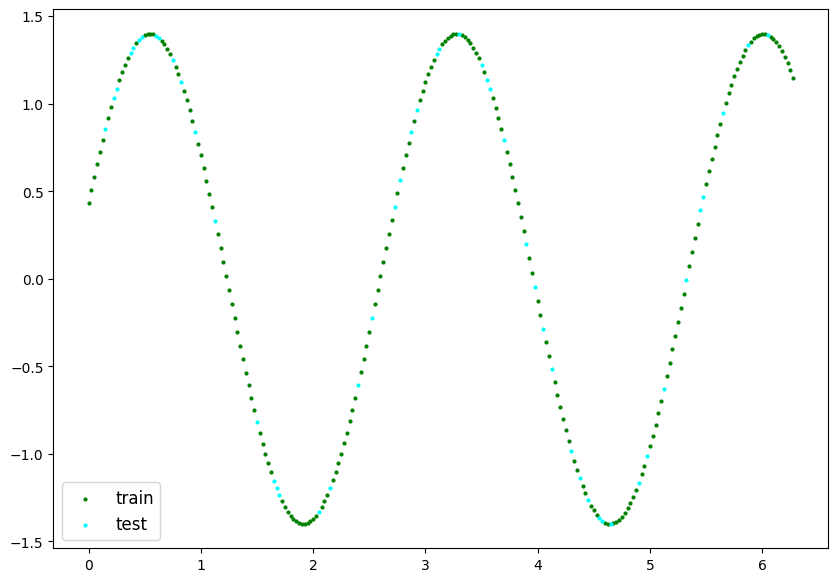

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.arange(0, 2.0 * np.pi, 0.025)
a = 1.4
f = 2.3 / (2.0 * np.pi)
phi = 0.1 * np.pi
y = a * np.sin(2.0 * np.pi * f * X + phi)

X = torch.from_numpy(X).type(torch.float).unsqueeze(dim=1)
y = torch.from_numpy(y).type(torch.float).unsqueeze(dim=1)

# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")

plot_data(X_train, y_train, X_test, y_test)

Create a model to guesstimate the points. As this function is a little mean this will not always 
converge.

model_0.parameters:
[Parameter containing:
tensor([1.5819], requires_grad=True), Parameter containing:
tensor([0.4485], requires_grad=True), Parameter containing:
tensor([0.0330], requires_grad=True)]

model_0.state_dict:
OrderedDict({'a': tensor([1.5819]), 'b': tensor([0.4485]), 'c': tensor([0.0330])})



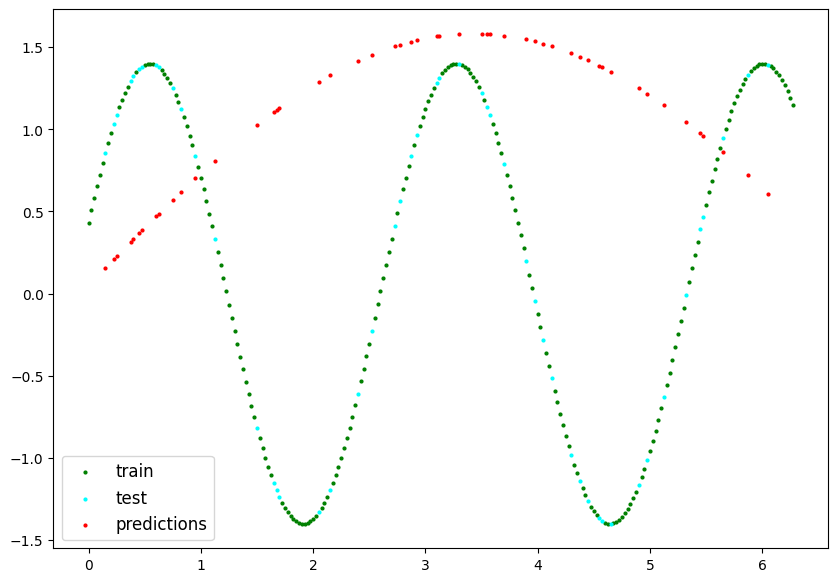

In [40]:
import torch.nn as nn


class WaveGuesserModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a =  nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.b =  nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.c =  nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    # Forward defines the computation in the model.
    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:  # "x" is the input data (e.g. training/testing features).
        # This is the wave function: sin(x) = a * sin(b * x + c)
        return self.a * torch.sin(self.b * x + self.c)


# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = WaveGuesserModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created.
print(f"model_0.parameters:\n{list(model_0.parameters())}\n")

# List named parameters.
print(f"model_0.state_dict:\n{model_0.state_dict()}\n")

# Make predictions with model.
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds)

Training and testing function

In [41]:
def train_model(
    model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer
) -> torch.Tensor:
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


def test_model(model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
    model.eval()

    with torch.inference_mode():
        test_pred = model(X_test)
        loss = loss_fn(
            test_pred,
            y_test.type(torch.float),
        )
        return loss

Train the model and see what happens.

Epoch: 0 | Train Loss: 1.5253826379776 | Test Loss: 1.5990194082260132
Epoch: 20 | Train Loss: 1.23287034034729 | Test Loss: 1.4230496883392334
Epoch: 40 | Train Loss: 1.1128382682800293 | Test Loss: 1.2633624076843262
Epoch: 60 | Train Loss: 1.036639928817749 | Test Loss: 1.1801682710647583
Epoch: 80 | Train Loss: 0.9891632199287415 | Test Loss: 1.1194658279418945
Epoch: 100 | Train Loss: 0.9616300463676453 | Test Loss: 1.0839591026306152
Epoch: 120 | Train Loss: 0.9469820857048035 | Test Loss: 1.0638502836227417
Epoch: 140 | Train Loss: 0.9398844242095947 | Test Loss: 1.052416205406189
Epoch: 160 | Train Loss: 0.9367501139640808 | Test Loss: 1.0462603569030762
Epoch: 180 | Train Loss: 0.9354761242866516 | Test Loss: 1.0427671670913696
Epoch: 200 | Train Loss: 0.9349867105484009 | Test Loss: 1.0406283140182495
Epoch: 220 | Train Loss: 0.93479984998703 | Test Loss: 1.0392175912857056
Epoch: 240 | Train Loss: 0.9347239136695862 | Test Loss: 1.0382214784622192
Epoch: 260 | Train Loss: 0.

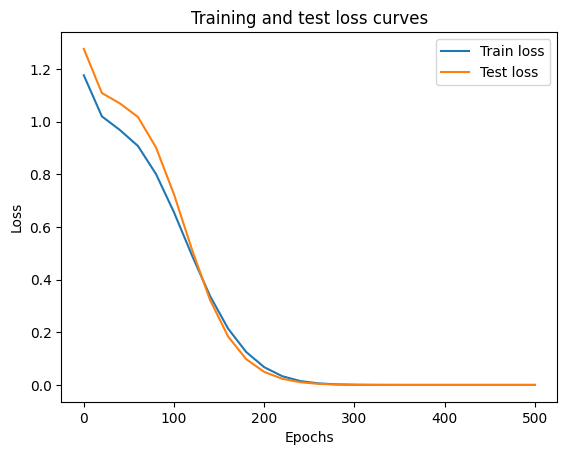

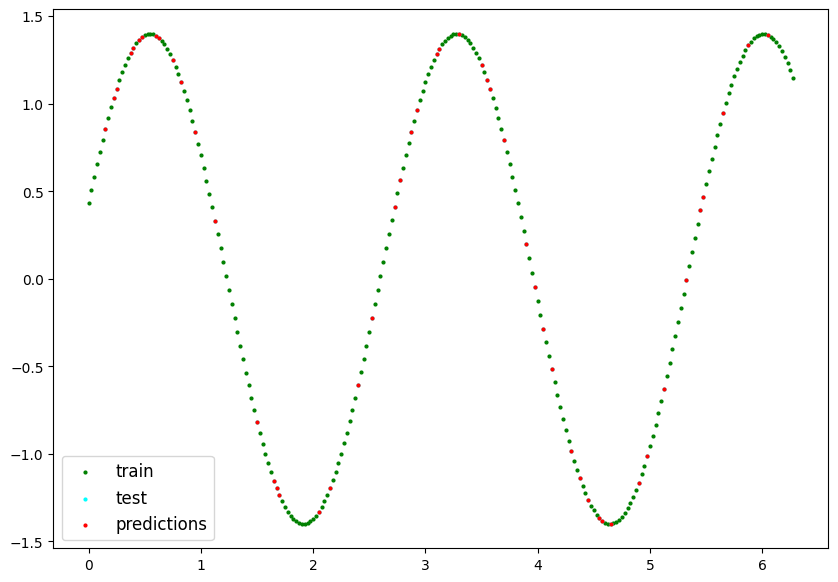

Error:
tensor([[-2.7418e-06],
        [-8.6427e-06],
        [-2.4438e-06],
        [-2.3246e-06],
        [-1.3709e-06],
        [-1.4305e-06],
        [ 3.2187e-06],
        [ 3.3379e-06],
        [-7.0333e-06],
        [ 5.1260e-06]], device='cuda:0')


In [ ]:
attempts = 0
while True:
    attempts += 1

    # Recreate the model.
    model_0 = WaveGuesserModel()

    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(
        params=model_0.parameters(),
        lr=0.01,
    )

    epochs = 500

    # Send the model to the target device (GPU or CPU).
    model_0.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Create empty loss lists to track values.
    train_loss_values = []
    test_loss_values = []
    epoch_count = []

    for epoch in range(epochs + 1):
        # Train the model.
        loss = train_model(model_0, loss_fn, optimizer)
        # Test the model.
        # Note: we don't need to pass the optimizer to the test function since we are not updating the
        # model parameters.
        test_loss = test_model(model_0, loss_fn)

        # Print out what's happening.
        with torch.inference_mode():
            if epoch % 50 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.detach().cpu().numpy())
                test_loss_values.append(test_loss.detach().cpu().numpy())
                print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

    if (loss < 0.01) and (test_loss < 0.01):
        print(f"Converged after {attempts} attempts.")
        print(f"Final model parameters:\n{model_0.state_dict()}")
        break
    else:
        print(f"Model parameters not converged, trying again...\n")
        continue


# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Make predictions with the trained model.
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_data(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

print(f"Error:\n{(y_test - y_preds)[:10]}")